In [1]:
import numpy as np
import os, glob, csv


import librosa

import sklearn

import torch
import torch.nn as nn
import torch.nn.functional as nnF


%matplotlib inline
import matplotlib.pyplot as plt

import math


from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import pyaudio
import wave
from queue import Queue
from threading import Thread
import sys
import time
import sounddevice as sd

import IPython.display as ipd
# use GPU if available, otherwise, use cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def extract_melspectrogram(audio,sr=22050, win_len=0.05, hop_len=0.025, n_mels=64):
#     audio, sr = librosa.load("{}".format(filename), sr=22050)
    win_len = int(win_len*sr)
    hop_len = int(hop_len*sr)
    spec = librosa.feature.melspectrogram(audio, sr, n_mels=n_mels, n_fft=2048, win_length=win_len, hop_length=hop_len)
    return spec.transpose((1,0))

#plt.imshow(librosa.power_to_db(x, ref=np.max), aspect='auto', origin='lower')

In [4]:
class DetectionModel(nn.Module):
    """The CNN model"""
    def __init__(self):
        
        super(DetectionModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64,
                               kernel_size=(5, 5), bias=False,padding="same")

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=(3, 3), bias=False,padding="same")

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=(3, 3), bias=False)

        self.fc1 = nn.Linear(128, 128, bias=True)
        self.fc2 = nn.Linear(128, 1, bias=True)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(128)


    def forward(self, x):
        (_, time_len, mel_bins) = x.shape

        x = x.view(-1, 1, time_len, mel_bins)
        # print('Input')
        # print(x.size())

        x = nnF.relu(self.bn1(self.conv1(x)))
        # print('Conv1')
        # print(x.size())
        x = nnF.max_pool2d(x,kernel_size=(2,4),padding=(0,2))
        # print('Pool1')
        # print(x.size())
        
        x = nnF.relu(self.bn2(self.conv2(x)))
        # print('Conv2')
        # print(x.size())
        x = nnF.max_pool2d(x,kernel_size=(3,3),padding=(1,1))
        # print('Pool2')
        # print(x.size())
        
        x = nnF.relu(self.bn3(self.conv3(x)))
        # print('Conv3')
        # print(x.size())
        x = nnF.max_pool2d(x,kernel_size=(5,4))
        # print('Pool3')
        # print(x.size())
        
        # flatten
        x = x.view(-1, self.num_flat_features(x))
        x = nnF.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))

        return x

    def forward_and_convert(self, x):
        "Handles the torch<--->numpy tensor conversion, for convenience"
        x_torch = torch.FloatTensor(x)
        y_torch = self.forward(x_torch)
        return y_torch.detach().numpy()
        
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [5]:
model = DetectionModel()

In [6]:
model.load_state_dict(torch.load("./best_model"))

<All keys matched successfully>

In [7]:
x_train = np.load("./train_test_val_data/train/x.npy")
y_train = np.load("./train_test_val_data/train/y.npy")

x_test = np.load("./train_test_val_data/test/x.npy")
y_test = np.load("./train_test_val_data/test/y.npy")

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20)

In [9]:
# data normalisation
scaler = StandardScaler()
# compute normalisation parameters based on the training data 
# QUESTION: why do we reshape the data to (-1,64)?
scaler.fit(x_train.reshape((-1,64)))
# print(scaler.mean_)

# normalise the training data with the computed parameters
x_train = scaler.transform(x_train.reshape((-1,64)))
x_train = x_train.reshape((-1, 41, 64)) # reverse back to the original shape
#print(train_data[0])

# normalise the test data with the computed parameters
x_test = scaler.transform(x_test.reshape((-1,64)))
x_test = x_test.reshape((-1, 41, 64)) # reverse back to the original shape
#print(test_data[0])

In [10]:
x_train[0:10].shape

(10, 41, 64)

In [11]:
y_train[0:10]

array([1., 0., 0., 1., 0., 1., 0., 0., 1., 1.])

In [12]:
batch_size = 4

In [13]:
def evaluate(model, data):
    pred = np.zeros(len(data)) # for storing predicted class labels, one for each data sample
    num_batch = len(data)//batch_size # number of batches in one data epoch
    # evaluate batch by batch and store the output to "pred"
    for i in range(num_batch):
        temp = model.forward_and_convert(data[i*num_batch : (i+1)*num_batch])
        # QUESTION: what does squeeze() function do?
        pred[i*num_batch : (i+1)*num_batch] = temp.squeeze()
    # some trailing data samples
    if(num_batch*batch_size < len(data)):
        temp = model.forward_and_convert(data[num_batch*batch_size :])
        pred[num_batch*batch_size :] = temp.squeeze()
    # each element in "pred" is the output after sigmoid function and has value in [0, 1].
    # to obtain the discrete label (0 or 1 in this case), we threshold the value by 0.5.
    pred[pred >= 0.5] = 1.
    pred[pred < 0.5] = 0.
    return pred

In [14]:
preds = evaluate(model, x_test)

In [15]:
accuracy_score(preds, y_test)

0.988013698630137

In [16]:
print(len(y_test))
print(sum(y_test))

584
306.0


In [17]:
q = Queue()
silence_threshold = 100
feed_samples=22050
data = np.zeros(feed_samples, dtype='int16') 
def callback(in_data, frame_count, time_info, status):
    global data
    data0 = np.frombuffer(in_data, dtype='int16')
    if np.abs(data0).mean() < silence_threshold:
        print("-",end=" ")
        return (in_data, pyaudio.paContinue)
    else:
        print(".",end=" ")
    data = np.append(data,data0)
    if len(data) > feed_samples:
        data = data[-feed_samples:]
    q.put(data)
    return (in_data, pyaudio.paContinue)
#     global run, timeout, data, silence_threshold    
#     if time.time() > timeout:
#         run = False        
#     data0 = np.frombuffer(in_data, dtype='int16')
#     if np.abs(data0).mean() < silence_threshold:
#         sys.stdout.write('-')
#         return (in_data, pyaudio.paContinue)
#     else:
#         sys.stdout.write('.')
#     data = np.append(data,data0)    
#     if len(data) > feed_samples:
#         data = data[-feed_samples:]
#         # Process data async by sending a queue.
#         q.put(data)
#     return (in_data, pyaudio.paContinue)

In [19]:
def preprocess_audio(audio_data):
    processed_audio = np.float64(audio_data)/32768

    return processed_audio

In [20]:
CHUNK = 1024*4
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 22050

In [21]:
p = pyaudio.PyAudio()

stream = p.open(
format= FORMAT,
channels = CHANNELS,
rate = RATE,
input = True,
#output = True,
frames_per_buffer = CHUNK,
stream_callback = callback
)

stream.start_stream()

while True:
    data = q.get()
    data = preprocess_audio(data)
    audio_spectogram = extract_melspectrogram(data)
    with torch.no_grad():
        pred = model(torch.FloatTensor(audio_spectogram[None,:]))
    if pred > 0.5:
        print("It worked !")
        print("prediction =", pred)
        break

stream.stop_stream()
stream.close()


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - . I did it !!!!!
prediction = tensor([[0.9933]])


In [35]:
np.min(data)
np.max(data)
len(data)

22050

In [36]:
sd.play(data, 44100/2)

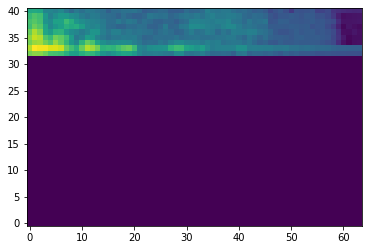

In [22]:
plt.imshow(librosa.power_to_db(audio_spectogram, ref=np.max), aspect='auto', origin='lower')

In [26]:
audio_spectogram[None,:].shape

(1, 41, 64)

In [120]:
model(torch.FloatTensor(x[None,:]))

tensor([[1.]], grad_fn=<SigmoidBackward0>)

In [106]:
x,sr= librosa.load("recording0.wav")#

In [107]:
x.shape

(22050,)

In [108]:
x = extract_melspectrogram(x)

In [109]:
x.shape

(41, 64)

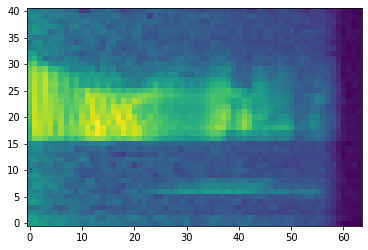

In [110]:
plt.imshow(librosa.power_to_db(x, ref=np.max), aspect='auto', origin='lower')

In [73]:
%cd ..

C:\Users\khalid\Desktop\QMUL\subjects\sem2\music\project\dataset\the simple approach


In [18]:
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv
  
# Sampling frequency
freq = 22050
  
# Recording duration
duration = 1
  
# Start recorder with the given values 
# of duration and sample frequency
recording = sd.rec(int(duration * freq), 
                   samplerate=freq, channels=1)
  
# Record audio for the given number of seconds
sd.wait()
  
# This will convert the NumPy array to an audio
# file with the given sampling frequency
write("recording0.wav", freq, recording)
  
# Convert the NumPy array to audio file
wv.write("recording1.wav", recording, freq, sampwidth=2)

(41, 64)


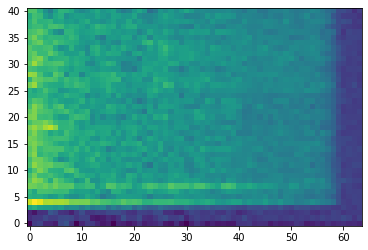

In [21]:
x = extract_melspectrogram(recording[:,0])
print(x.shape)
plt.imshow(librosa.power_to_db(x, ref=np.max), aspect='auto', origin='lower')

In [20]:
while True:
    recording = sd.rec(int(duration * freq), 
                   samplerate=freq, channels=1)
  
    # Record audio for the given number of seconds
    sd.wait()
    
    x = extract_melspectrogram(recording[:,0])
#     x = scaler.transform(x.reshape((-1,64)))
#     x = x.reshape((-1, 41, 64)) # reverse back to the original shape
    with torch.no_grad():
        pred = model(torch.FloatTensor(x[None,:]))
#     print(pred.item(),end=" ")
    if pred >=0.9:
        print("1",end=" ")
    else:
        print(".",end=" ")

. . . . . . . . . . . . . . . . . . 1 1 . . . 

KeyboardInterrupt: 